In [1]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt

from lib.projected_kernel import densities_2_kernel, get_independent_kernel_entries
from lib.exponential_fitting import show_elbow_n, fit_exponential_n

from scipy.stats import iqr

from lib.spread_N_estimation import N_spread, N_spread_noisy, V_k, V_k_noisy
from lib.success_rate_N_estimation import get_N_success_rate_array, get_rho, get_N_success_rate

from tqdm.auto import tqdm

/Users/amiroszewski/opt/anaconda3/envs/quantum/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Import data

In [2]:
path_2_rdms = '../results/indian/reduced_density_matrices/full'

files = []
for file in os.listdir(path_2_rdms):
    if file.endswith('.npy'):
        files.append(os.path.join(path_2_rdms, file))
files.sort()

In [168]:
r=5

In [169]:
files_ZZ = [f for f in files if 'ZZ_'+str(r) in f]

In [170]:
files_ZZ

['../results/indian/reduced_density_matrices/full/densities_02_ZZ_5.npy',
 '../results/indian/reduced_density_matrices/full/densities_03_ZZ_5.npy',
 '../results/indian/reduced_density_matrices/full/densities_04_ZZ_5.npy',
 '../results/indian/reduced_density_matrices/full/densities_05_ZZ_5.npy',
 '../results/indian/reduced_density_matrices/full/densities_06_ZZ_5.npy',
 '../results/indian/reduced_density_matrices/full/densities_07_ZZ_5.npy',
 '../results/indian/reduced_density_matrices/full/densities_08_ZZ_5.npy',
 '../results/indian/reduced_density_matrices/full/densities_09_ZZ_5.npy',
 '../results/indian/reduced_density_matrices/full/densities_10_ZZ_5.npy']

In [171]:
RDMs = []
for f in files_ZZ:
    RDMs.append(np.load(f))

In [172]:
m = RDMs[0].shape[0]

In [173]:
path_2_k = '../results/indian/PQ_ie/full'

files_k = []
for file in os.listdir(path_2_k):
    if file.endswith('.npy'):
        files_k.append(os.path.join(path_2_k, file))
files_k.sort()

In [174]:
files_ZZ_k = [f for f in files_k if 'ZZ_'+str(r) in f]
ies = np.array([np.load(f) for f in files_ZZ_k])

In [175]:
files_ZZ_k

['../results/indian/PQ_ie/full/IE_02_ZZ_5.npy',
 '../results/indian/PQ_ie/full/IE_03_ZZ_5.npy',
 '../results/indian/PQ_ie/full/IE_04_ZZ_5.npy',
 '../results/indian/PQ_ie/full/IE_05_ZZ_5.npy',
 '../results/indian/PQ_ie/full/IE_06_ZZ_5.npy',
 '../results/indian/PQ_ie/full/IE_07_ZZ_5.npy',
 '../results/indian/PQ_ie/full/IE_08_ZZ_5.npy',
 '../results/indian/PQ_ie/full/IE_09_ZZ_5.npy',
 '../results/indian/PQ_ie/full/IE_10_ZZ_5.npy']

# Kernel entries, error budget

## Kernel concentration

In [176]:
n_range_sim = np.arange(2,2+len(files_ZZ_k))

In [177]:
k_conc = 1-np.median(ies, axis=1)

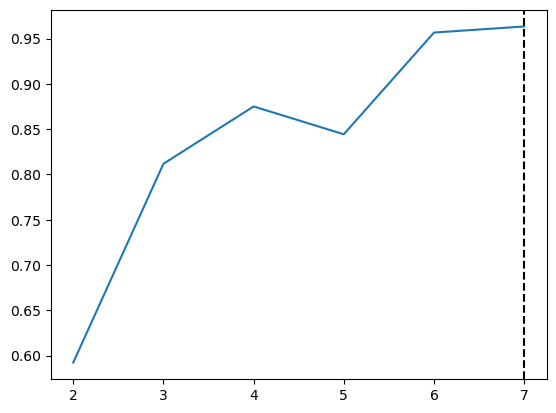

Best qubit score:  0.9632925486185792
Fit NOT good enough


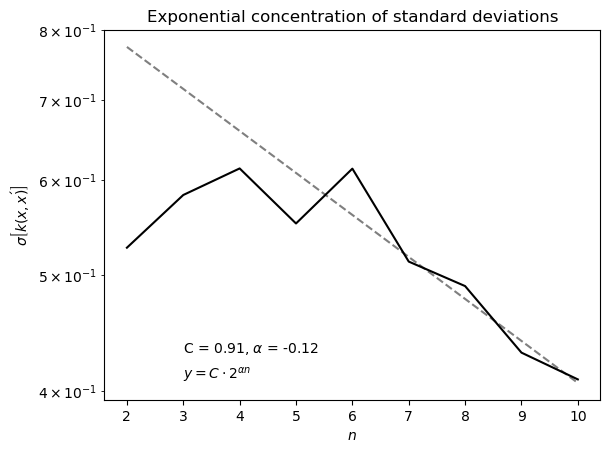

In [179]:
best_qubit = 7
show_elbow_n(k_conc, best_qubit=best_qubit)
alpha_M, C_M = fit_exponential_n(k_conc, best_qubit=best_qubit)

In [180]:
n_range = np.array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  15,  20,  30,  40,
        50,  60,  70,  80,  90, 100])

kappa_extrapolated = C_M*np.power(2, alpha_M *n_range)

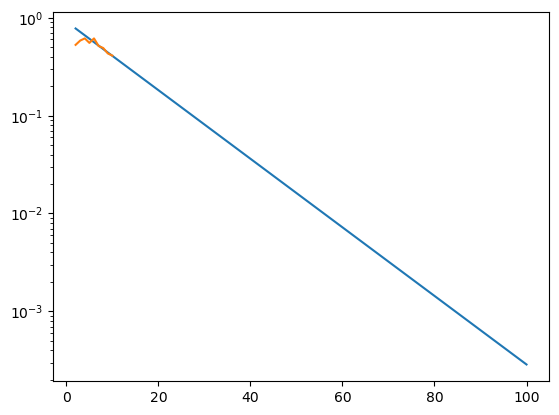

In [181]:
plt.plot(n_range, kappa_extrapolated)
plt.plot(n_range_sim, k_conc)
plt.yscale('log')
plt.show()

## IQR

In [182]:
k_iqr = iqr(ies, axis=1)

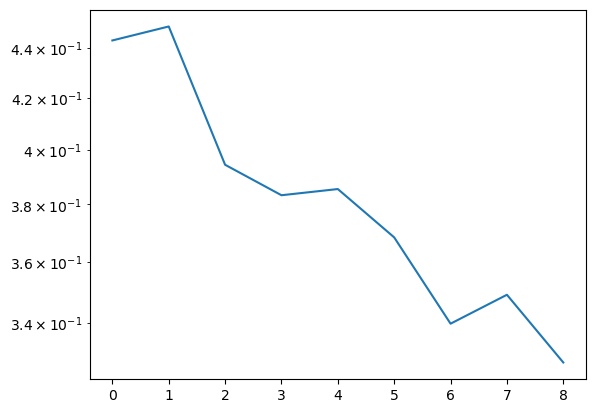

In [183]:
plt.plot(k_iqr)
plt.yscale('log')

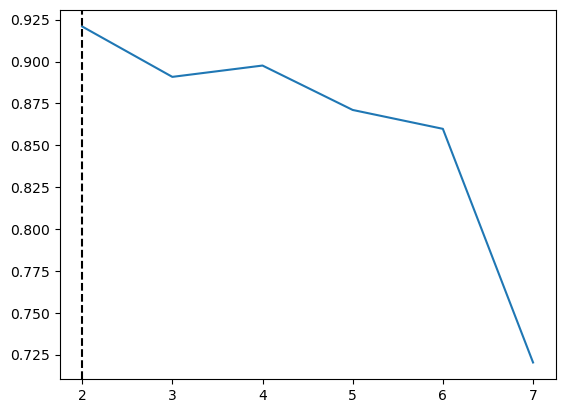

Best qubit score:  0.9209304461694878
Fit NOT good enough


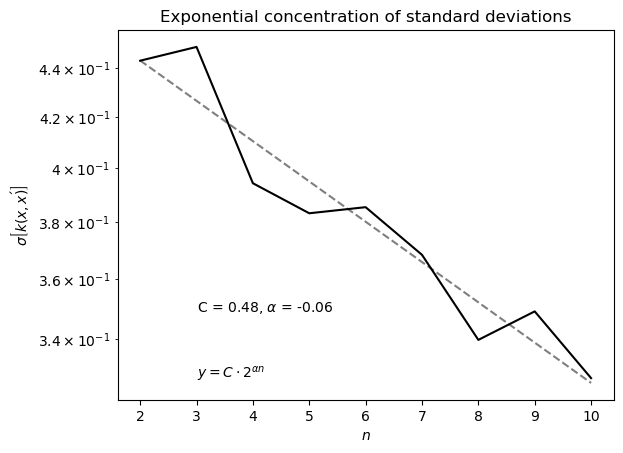

In [185]:
best_qubit = 2
show_elbow_n(k_iqr, best_qubit = best_qubit)
alpha_iqr, C_iqr = fit_exponential_n(k_iqr, best_qubit=best_qubit)

In [186]:
iqrs = C_iqr*np.power(2,alpha_iqr*n_range)

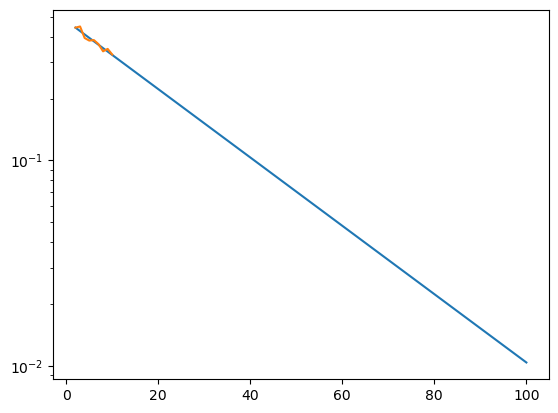

In [187]:
plt.plot(n_range, iqrs)
plt.plot(n_range_sim, k_iqr)
plt.yscale('log')
plt.show()

## Error budget

In [188]:
def error_budget(Delta, Kappa):
    """ 
    p <= Delta/( 4 | 1-Kappa | )
    """
    p = Delta/(4*np.abs(1-Kappa))
    return(p)

In [189]:
error_budget(iqrs, kappa_extrapolated)

array([0.49172223, 0.37372519, 0.30123701, 0.25212096, 0.21659496,
       0.18966802, 0.16852711, 0.15146606, 0.13738998, 0.09243216,
       0.06791182, 0.0412309 , 0.02679642, 0.01789353, 0.01208699,
       0.00820593, 0.00558348, 0.00380287, 0.00259126])

# Input from the Azure QRE

In [191]:
data = {
    'n': [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 15.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0],
    'error_budget': [0.491722, 0.373725, 0.301237, 0.252121, 0.216595, 0.189668, 0.168527, 0.151466, 0.13739, 0.092432, 0.067912, 0.041231, 0.026796, 0.017894, 0.012087, 0.008206, 0.005583, 0.003803, 0.002591],
    'physical_qubits': [550.0, 34600.0, 87710.0, 99764.0, 115640.0, 131614.0, 113810.0, 257256.0, 277020.0, 369684.0, 680988.0, 889834.0, 1480102.0, 1636258.0, 2602350.0, 3152250.0, 3324150.0, 3090224.0, 3624940.0],
    'runtime': [214000.0, 466000.0, 952000.0, 1209600.0, 1481200.0, 1890000.0, 2836800.0, 3261600.0, 3704400.0, 6519600.0, 12223200.0, 22374000.0, 41662400.0, 58536400.0, 92184000.0, 120546000.0, 149736000.0, 206182800.0, 250158400.0],
}

df = pd.DataFrame(data)

# Save DataFrame to CSV
#df.to_csv('indian_Azure_5.csv', index=False)

In [192]:
df

,n,error_budget,physical_qubits,runtime
0,2.0,0.491722,550.0,214000.0
1,3.0,0.373725,34600.0,466000.0
2,4.0,0.301237,87710.0,952000.0
3,5.0,0.252121,99764.0,1209600.0
4,6.0,0.216595,115640.0,1481200.0
5,7.0,0.189668,131614.0,1890000.0
6,8.0,0.168527,113810.0,2836800.0
7,9.0,0.151466,257256.0,3261600.0
8,10.0,0.137390,277020.0,3704400.0
9,15.0,0.092432,369684.0,6519600.0


# N_spread

In [193]:
N_spread(RDMs[0][0],RDMs[0][1], iqrs[0], P_target=0.99)

1168.4122167165704

In [194]:
N_spread_noisy(RDMs[0][0],RDMs[0][1], iqrs[0], P_target=0.99)

6395.771120765185

In [195]:
len(RDMs)

9

In [196]:
int(m*(m-1)/2)


1065070

In [197]:
"""
P_target = 0.99

N_spreads = np.empty((len(RDMs), int(m*(m-1)/2)))
N_spreads_noisy = np.empty((len(RDMs), int(m*(m-1)/2)))

for id in range(len(RDMs)):
    print('id: ', id, ' of: ',len(RDMs)-1)
    RDMs_qubit = RDMs[id]
    Delta = iqrs[id]

    N_spread_qubit = []
    N_spread_noisy_qubit = []
    for i in tqdm(range(RDMs_qubit.shape[0])):
        for j in range(i):
            rho_1 = RDMs_qubit[i]
            rho_2 = RDMs_qubit[j]
            N_spread_qubit.append(N_spread(rho_1, rho_2, Delta, P_target))
            N_spread_noisy_qubit.append(N_spread_noisy(rho_1, rho_2, Delta, P_target))
    
    N_spread_qubit = np.array(N_spread_qubit)
    N_spread_noisy_qubit = np.array(N_spread_noisy_qubit)

    N_spreads[id] = N_spread_qubit
    N_spreads_noisy[id] = N_spread_noisy_qubit
N_spread_qubit = np.array(N_spread_qubit)
N_spread_noisy_qubit = np.array(N_spread_noisy_qubit)
"""

"\nP_target = 0.99\n\nN_spreads = np.empty((len(RDMs), int(m*(m-1)/2)))\nN_spreads_noisy = np.empty((len(RDMs), int(m*(m-1)/2)))\n\nfor id in range(len(RDMs)):\n    print('id: ', id, ' of: ',len(RDMs)-1)\n    RDMs_qubit = RDMs[id]\n    Delta = iqrs[id]\n\n    N_spread_qubit = []\n    N_spread_noisy_qubit = []\n    for i in tqdm(range(RDMs_qubit.shape[0])):\n        for j in range(i):\n            rho_1 = RDMs_qubit[i]\n            rho_2 = RDMs_qubit[j]\n            N_spread_qubit.append(N_spread(rho_1, rho_2, Delta, P_target))\n            N_spread_noisy_qubit.append(N_spread_noisy(rho_1, rho_2, Delta, P_target))\n    \n    N_spread_qubit = np.array(N_spread_qubit)\n    N_spread_noisy_qubit = np.array(N_spread_noisy_qubit)\n\n    N_spreads[id] = N_spread_qubit\n    N_spreads_noisy[id] = N_spread_noisy_qubit\nN_spread_qubit = np.array(N_spread_qubit)\nN_spread_noisy_qubit = np.array(N_spread_noisy_qubit)\n"

In [198]:
P_target = 0.99

V = np.empty((len(RDMs), int(m*(m-1)/2)))
V_noisy = np.empty((len(RDMs), int(m*(m-1)/2)))

for id in range(len(RDMs)):
    print('id: ', id, ' of: ',len(RDMs)-1)
    RDMs_qubit = RDMs[id]
    Delta = iqrs[id]

    V_qubit = []
    V_noisy_qubit = []
    for i in tqdm(range(RDMs_qubit.shape[0])):
        for j in range(i):
            k_max = RDMs_qubit.shape[1]
            rho_1 = RDMs_qubit[i]
            rho_2 = RDMs_qubit[j]
            V_kk=[]
            V_kk_noisy=[]
            for k in range(k_max):
                V_kk.append(V_k(k, rho_1, rho_2))
                V_kk_noisy.append(V_k_noisy(k, rho_1, rho_2))
            V_qubit.append(np.mean(V_kk))
            V_noisy_qubit.append(np.mean(V_kk_noisy))
    V_qubit = np.array(V_qubit)
    V_noisy_qubit = np.array(V_noisy_qubit)

    V[id] = V_qubit
    V_noisy[id] = V_noisy_qubit

id:  0  of:  8


100%|██████████| 1460/1460 [01:35<00:00, 15.36it/s]


id:  1  of:  8


100%|██████████| 1460/1460 [02:15<00:00, 10.81it/s]


id:  2  of:  8


100%|██████████| 1460/1460 [02:56<00:00,  8.26it/s]


id:  3  of:  8


100%|██████████| 1460/1460 [03:37<00:00,  6.72it/s]


id:  4  of:  8


100%|██████████| 1460/1460 [04:18<00:00,  5.65it/s]


id:  5  of:  8


100%|██████████| 1460/1460 [04:58<00:00,  4.89it/s]


id:  6  of:  8


100%|██████████| 1460/1460 [05:34<00:00,  4.37it/s]


id:  7  of:  8


100%|██████████| 1460/1460 [06:11<00:00,  3.93it/s]


id:  8  of:  8


100%|██████████| 1460/1460 [06:51<00:00,  3.54it/s]


In [199]:
V_m = np.median(V,axis=1)
V_m_noisy = np.median(V_noisy, axis=1)

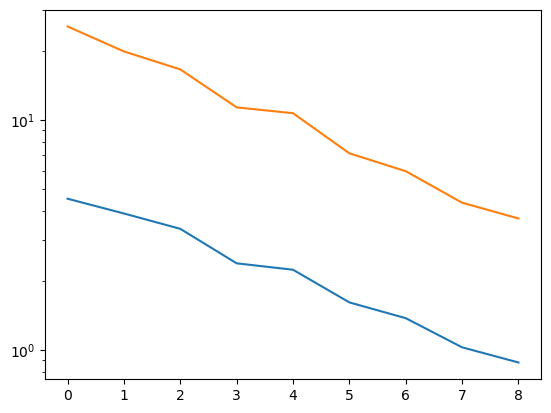

In [200]:
plt.plot(V_m)
plt.plot(V_m_noisy)
plt.yscale('log')
plt.show()

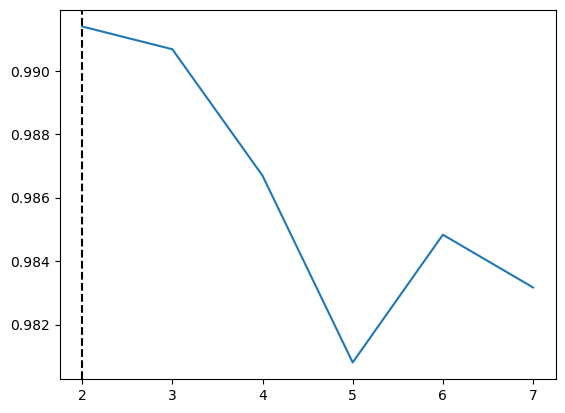

Best qubit score:  0.991395450573641
GOOD fit


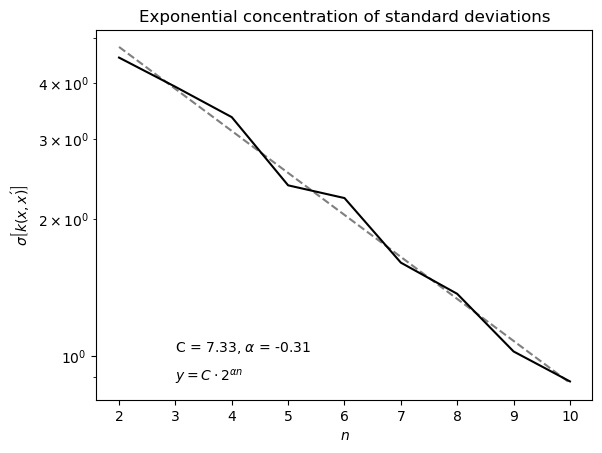

In [217]:
show_elbow_n(V_m, best_qubit=2)
alpha_Vm, C_Vm = fit_exponential_n(V_m, best_qubit=2)

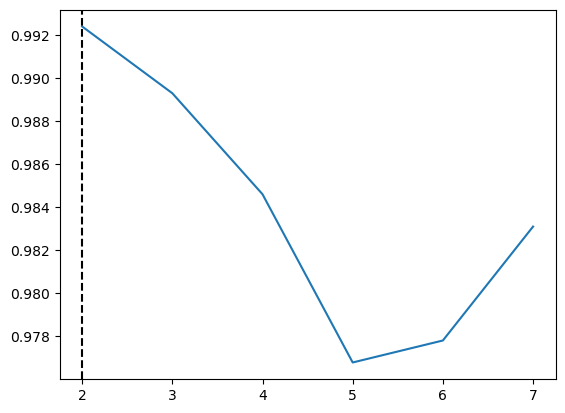

Best qubit score:  0.9923978540449465
GOOD fit


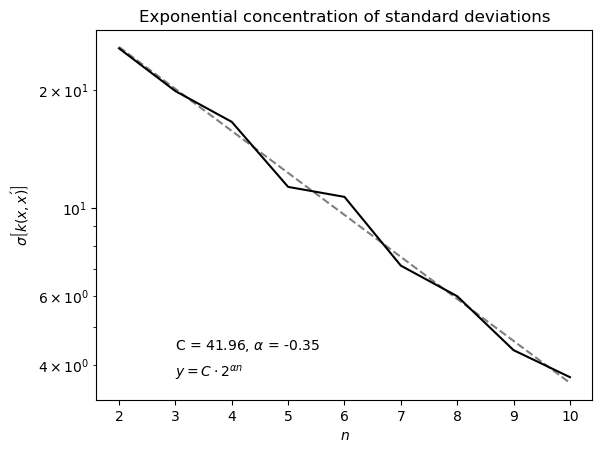

In [218]:
show_elbow_n(V_m_noisy, best_qubit=2)
alpha_Vm_noisy, C_Vm_noisy = fit_exponential_n(V_m_noisy, best_qubit=2)

In [219]:
#np.save('indian_Vmean_5.npy',V)
#np.save('indian_Vmean_noisy_5.npy',V_noisy)

In [220]:
N_spreads = np.load('indian_N_spreads.npy')
N_spreads_noisy = np.load('indian_N_spreads_noisy.npy')

In [221]:
#np.save('indian_N_spreads_5.npy',N_spreads)
#np.save('indian_N_spreads_noisy_5.npy',N_spreads_noisy)

In [222]:
N_s = np.median(N_spreads, axis=1)
N_s_noisy = np.median(N_spreads_noisy, axis=1)

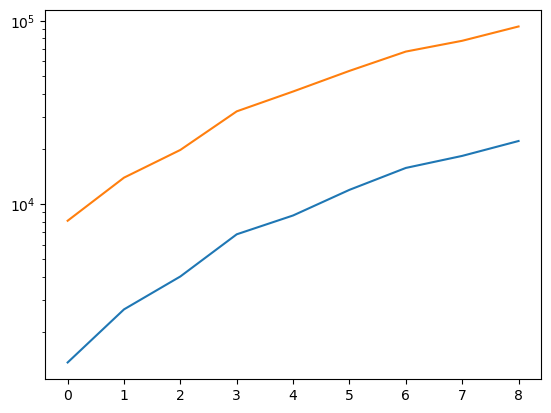

In [225]:
plt.plot(N_s)
plt.plot(N_s_noisy)
plt.yscale('log')
plt.show()

In [226]:
V_mean = np.array([(N_s[i]*(1-P_target)*np.power(k_iqr[i],2))/((n_range[i]**2)*(1-k_conc[i])) for i in range(len(N_s))])
V_mean_noisy = np.array([(N_s_noisy[i]*(1-P_target)*np.power(k_iqr[i],2))/((n_range[i]**2)*(1-k_conc[i])) for i in range(len(N_s))])

In [228]:
def N_spread_ext(n_range, k_fit, delta_fit, V_fit, P_target=0.99, gamma=1):
    k_ext = k_fit[1]*np.power(2,k_fit[0]*n_range)
    delta_ext = delta_fit[1]*np.power(2,delta_fit[0]*n_range)
    V_ext = V_fit[1]*np.power(2,V_fit[0]*n_range)
    print(V_ext.shape)
    N = np.array([(np.power(n_range[i]*gamma*k_ext[i],2)*V_ext[i])/((1-P_target)*np.power(delta_ext[i],2)) for i in range(n_range.shape[0])])
    return(N)

In [229]:
kappa_extrapolated

array([7.74658329e-01, 7.14658893e-01, 6.59306580e-01, 6.08241457e-01,
       5.61131470e-01, 5.17670281e-01, 4.77575282e-01, 4.40585752e-01,
       4.06461164e-01, 2.71620219e-01, 1.81511913e-01, 8.10571279e-02,
       3.61973926e-02, 1.61645406e-02, 7.21854126e-03, 3.22355824e-03,
       1.43953291e-03, 6.42847080e-04, 2.87073929e-04])

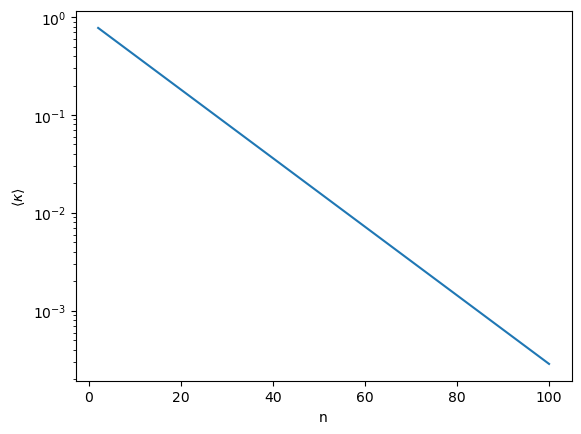

In [251]:
plt.plot(n_range, kappa_extrapolated)
plt.xlabel('n')
plt.ylabel(r'$\langle \kappa \rangle$')
plt.yscale('log')
plt.show()

In [230]:
N_ext = N_spread_ext(n_range=n_range, k_fit=(alpha_M, C_M), delta_fit=(alpha_iqr, C_iqr), V_fit=(alpha_Vm, C_Vm))
N_ext_noisy = N_spread_ext(n_range=n_range, k_fit=(alpha_M, C_M), delta_fit=(alpha_iqr, C_iqr), V_fit=(alpha_Vm_noisy, C_Vm_noisy))

(19,)
(19,)


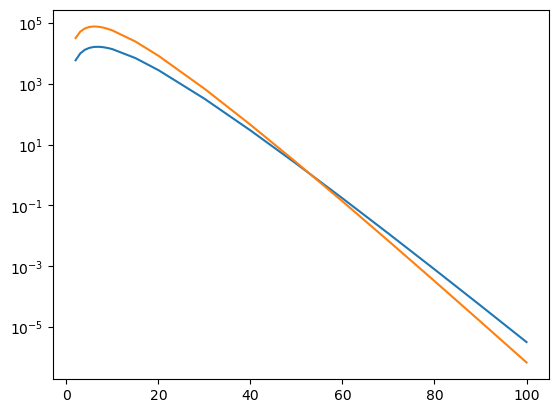

In [231]:
plt.plot(n_range, N_ext)
plt.plot(n_range, N_ext_noisy)
plt.yscale('log')
plt.show()

# N_SR

In [280]:
N_SRs = get_N_success_rate_array(RDMs[4], P_SR=0.99, mu=1/2)

N not found withing the given accuracy
N not found withing the given accuracy
N not found withing the given accuracy
N not found withing the given accuracy
N not found withing the given accuracy
N not found withing the given accuracy
N not found withing the given accuracy
N not found withing the given accuracy
N not found withing the given accuracy
N not found withing the given accuracy
N not found withing the given accuracy
N not found withing the given accuracy
N not found withing the given accuracy
N not found withing the given accuracy
N not found withing the given accuracy
N not found withing the given accuracy
N not found withing the given accuracy
N not found withing the given accuracy
N not found withing the given accuracy
N not found withing the given accuracy
N not found withing the given accuracy
N not found withing the given accuracy
N not found withing the given accuracy
N not found withing the given accuracy
N not found withing the given accuracy
N not found withing the g

In [281]:
N_SRs.shape

(1460, 6, 3)

In [282]:
np.mean(np.min(np.min(N_SRs, axis=2), axis=1))

25.55

In [234]:
RDMs[0].shape

(1460, 2, 2, 2)

In [235]:
representative_rhos = get_rho(kappa_extrapolated, n_range)

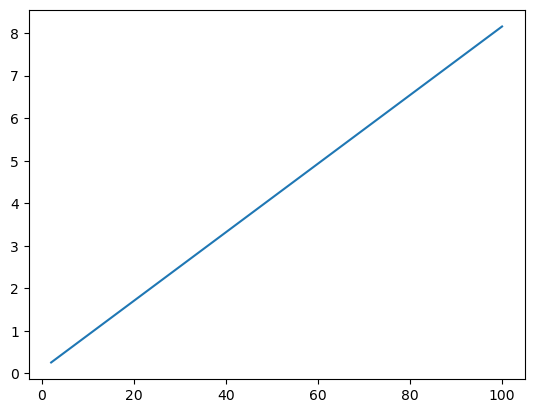

In [260]:
plt.plot(n_range,-np.log(kappa_extrapolated))
plt.show()

In [243]:
N_SRs_ext = [get_N_success_rate(0.99, 1/2, 1/2-representative_rhos[i]) for i in range(n_range.shape[0])]

In [244]:
N_SRs_ext

[74.0,
 87.0,
 89.0,
 93.0,
 94.0,
 94.0,
 98.0,
 98.0,
 100.0,
 100.0,
 108.0,
 108.0,
 110.0,
 110.0,
 110.0,
 110.0,
 110.0,
 110.0,
 110.0]

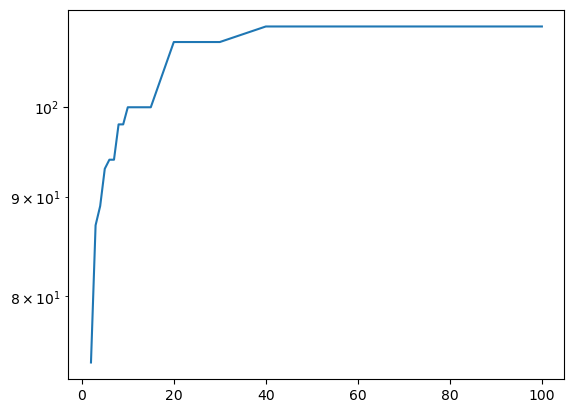

In [237]:
plt.plot(n_range, N_SRs_ext)
plt.yscale('log')
plt.show()

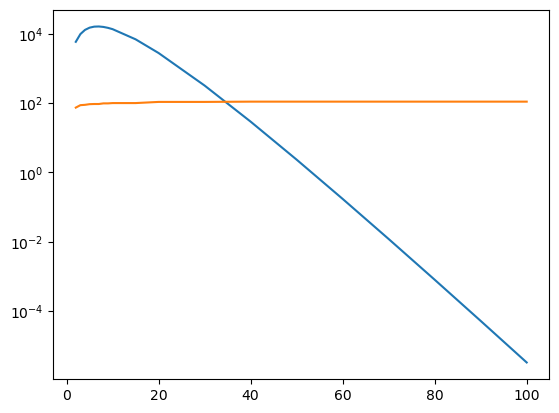

In [238]:
plt.plot(n_range, N_ext)
plt.plot(n_range, N_SRs_ext)
plt.yscale('log')